In [21]:
library(dplyr)
library(ggplot2)
library(data.table)

setwd("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM")

source("/mnt/lareaulab/reliscu/code/ggplot_theme.R")

theme_set(default_theme())

Verify enriched modules actually represent a given cell type by plotting cell type abundance vs. the module eigengene

In [31]:
get_top_corr_mods <- function(network_dir, pseudobulk_legend, top_qval_mods_df) {
    ctypes <- top_qval_mods_df$Cell_type
    top_corr_mods_list <- vector(mode="list", length=length(ctypes))

    for (i in seq_along(ctypes)) {
        # Get working cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        if (var(frac_per_sample) > 0) {
            # Get most enriched cell type module
            old_mod <- top_qval_mods_df$Module[i]
            ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
            ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]
            old_corr <- cor(frac_per_sample, ME_vec)

            # Traverse networks to find module most correlated to cell type abundance
            networks <- list.dirs(file.path(getwd(), network_dir), full.names=TRUE, recursive=FALSE)
            networks <- networks[lengths(lapply(networks, list.files)) > 0]
            ME_corrs_list <- lapply(seq_along(networks), function(j) {
                ME_path <- list.files(networks[j])[grep("eigengene", list.files(networks[j]))]
                ME_df <- fread(file.path(networks[j], ME_path), data.table=FALSE)

                ME_corrs <- apply(ME_df[,-1, drop=FALSE], 2, function(ME) {
                    cor(ME, frac_per_sample)
                })

                new_mod <- names(which.max(ME_corrs))
                new_corr <- ME_corrs[which.max(ME_corrs)]
                
                # Save the network the module came from
                network_id <- sapply(strsplit(networks[j], "/"), function(x) x[length(x)])
                
                data.frame(
                    Cell_type=ctypes[i],
                    Cor=new_corr,
                    Old_cor=old_corr,
                    Module=new_mod,
                    Old_module=old_mod,
                    Network=network_id,
                    Old_network=top_qval_mods_df$Network[i],
                    Pseudobulk_SD=round(sd(n_cells_per_sample), 2),
                    New_ME_path=file.path(networks[i], ME_path)
                )
            })
            ME_corrs <- do.call(rbind, ME_corrs_list)
            
            top_corr_mods_list[[i]] <- ME_corrs %>%
                arrange(Network, Module) %>%
                slice_max(Cor, with_ties=F)
        }
    }

    top_corr_mods_df <- do.call(rbind, top_corr_mods_list)
    top_corr_mods_df %>%
        arrange(Cor)
}

plot_ctype_abundance_vs_ME <- function(pseudobulk_legend, top_qval_mods_df) {
    ctypes <- top_qval_mods_df$Cell_type

    for (i in seq_along(ctypes)) {
        # Get cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        # Get eigengene from most enriched cell type module
        mod <- top_qval_mods_df$Module[i]
        ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
        ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

        df <- data.frame(Frac=frac_per_sample, ME=ME_vec)

        subtitle <- paste(
            top_qval_mods_df$Module[i], top_qval_mods_df$Network_short[i], "\n",
            "Cor:", round(cor(frac_per_sample, ME_vec), 2), "\n",
            "Qval =", formatC(top_qval_mods_df$Qval[i], format="e", digits=1) 
        )

        # Plot cell type proportion vs. module eigengene
        
        print(
            ggplot(df, aes(x=Frac*100, y=ME)) +
                geom_point() +
                theme(
                    plot.title=element_text(hjust=0.5),
                    plot.subtitle=element_text(hjust=0.5),
                    axis.title.x=element_text(size=14),
                    axis.title.y=element_text(size=14)
                ) +
                labs(
                    title=ctypes[i], 
                    subtitle=subtitle
                ) +
                xlab("% cells per sample") +
                ylab("Module eigengene")
        )
    }
    
}

# Round 2 enrichment results (only using unique DE genes, PosFDR module definiton)

In [29]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

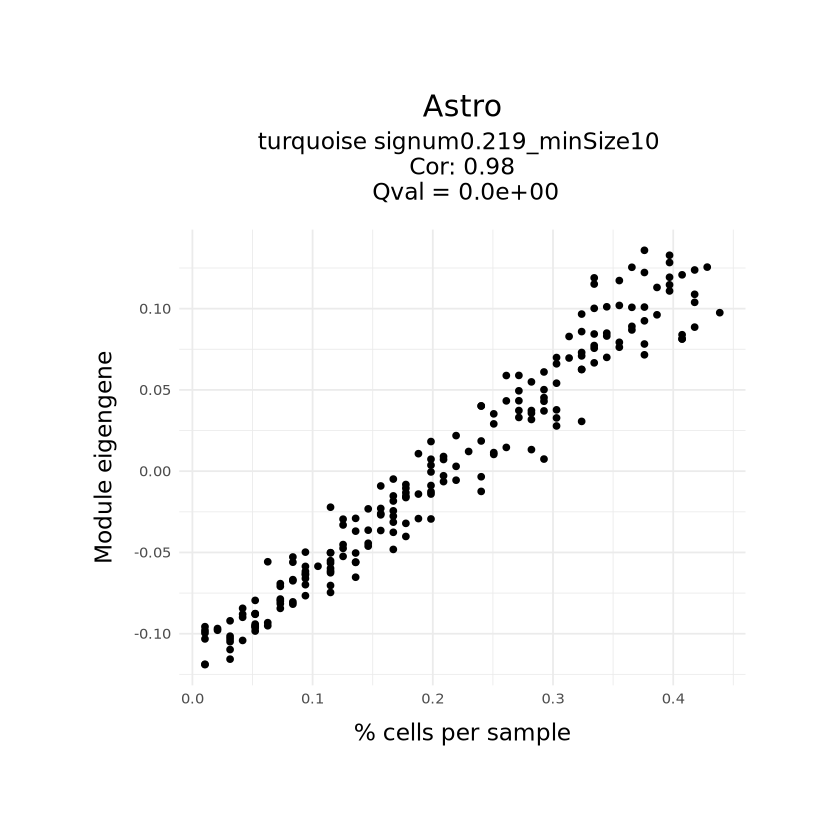

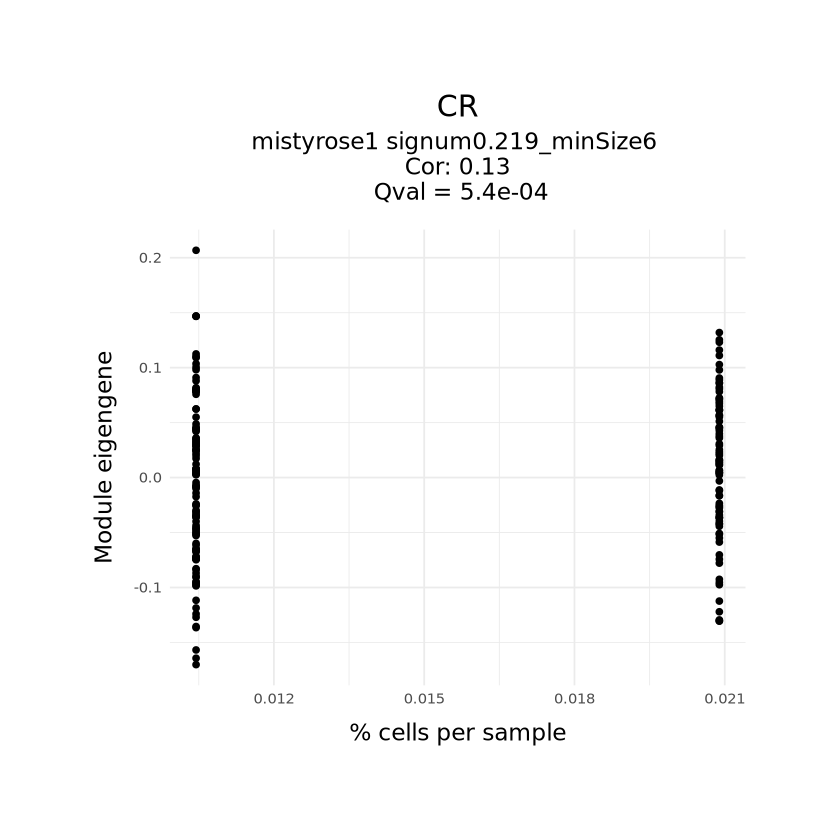

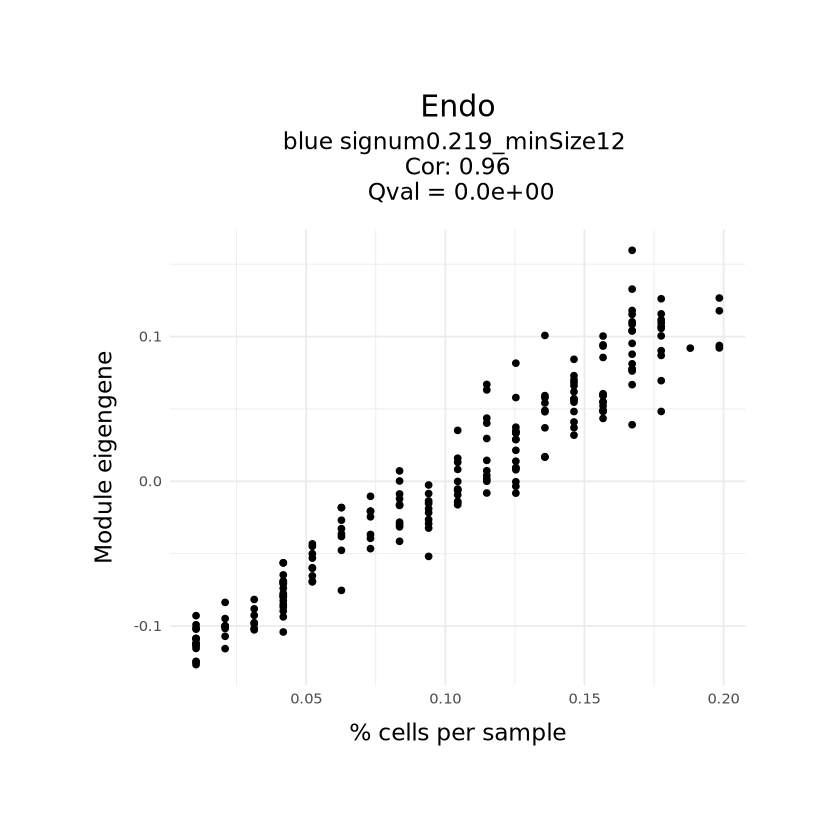

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


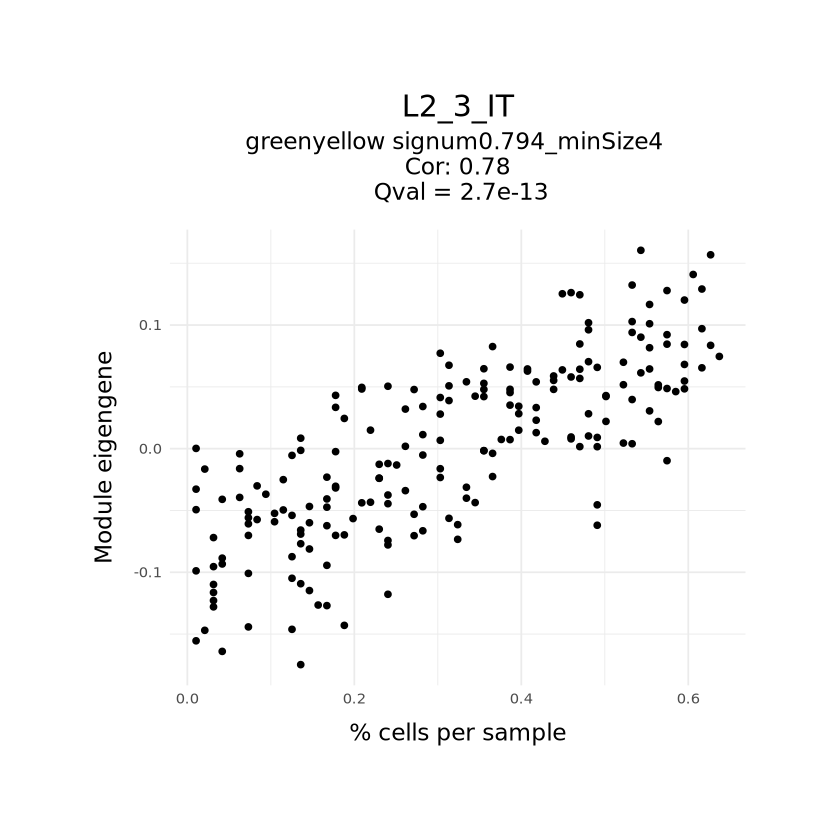

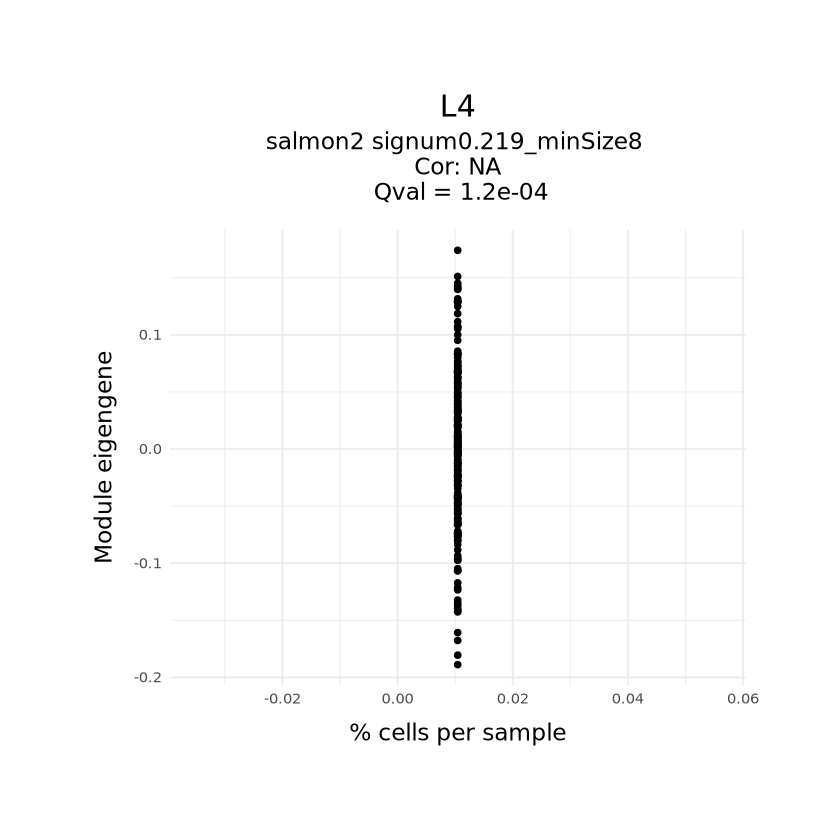

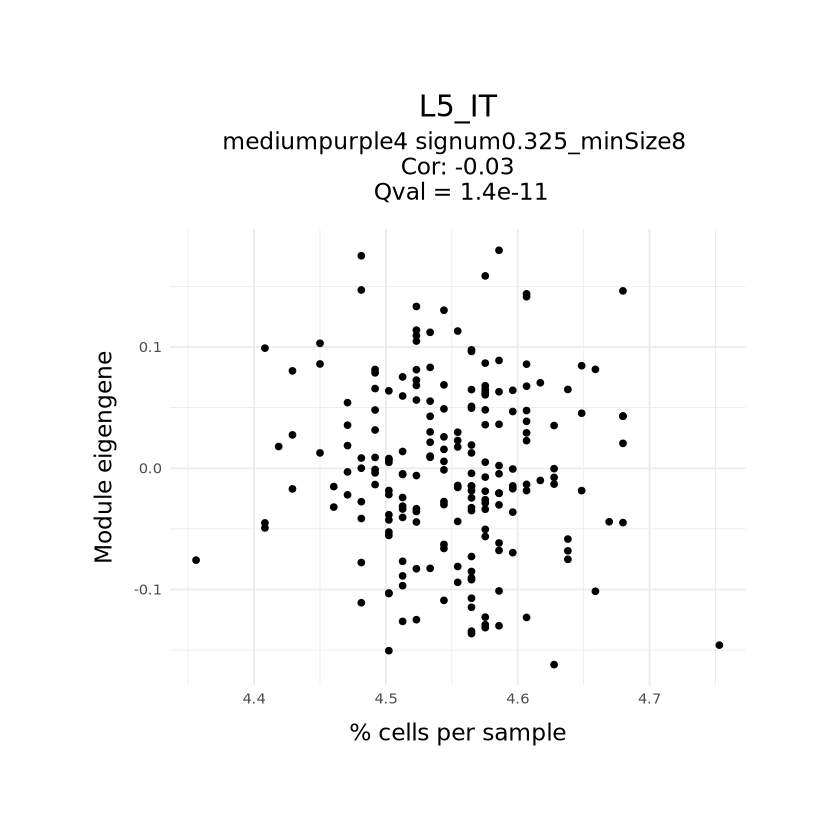

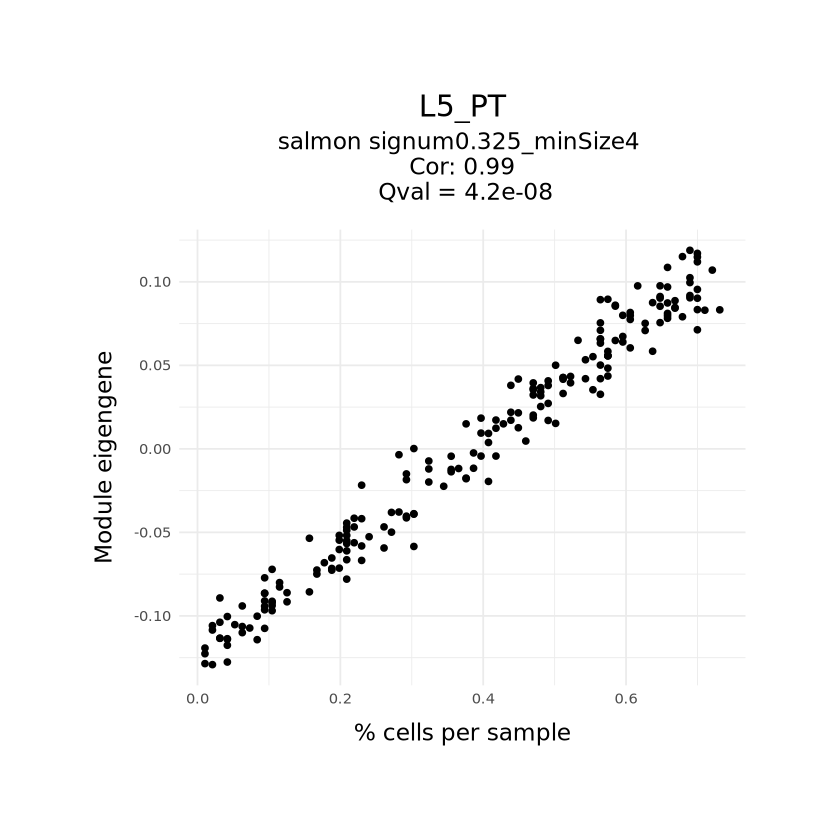

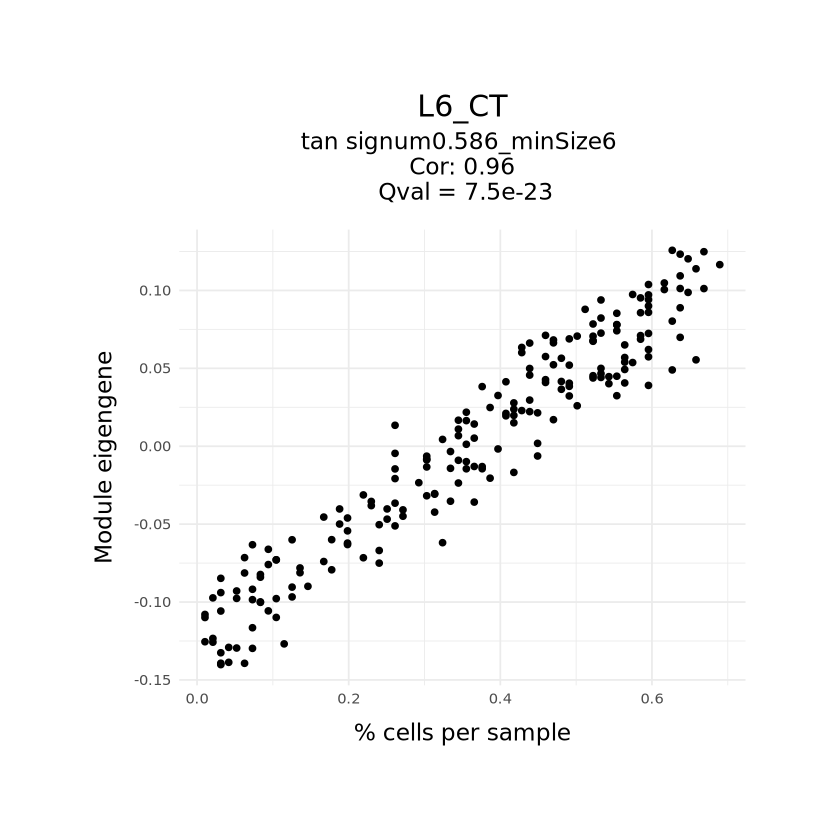

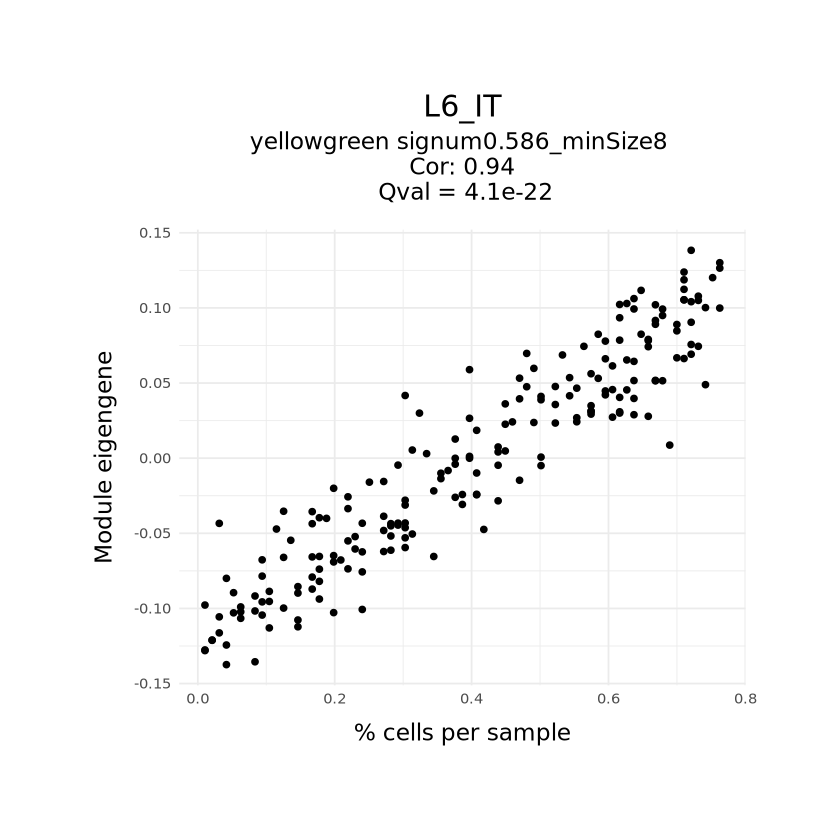

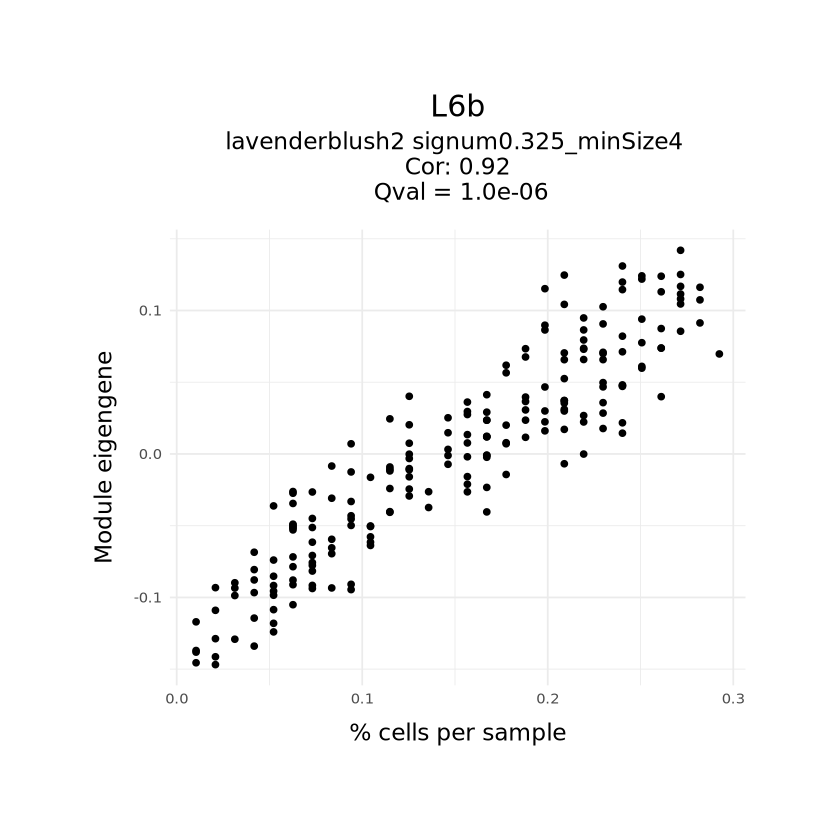

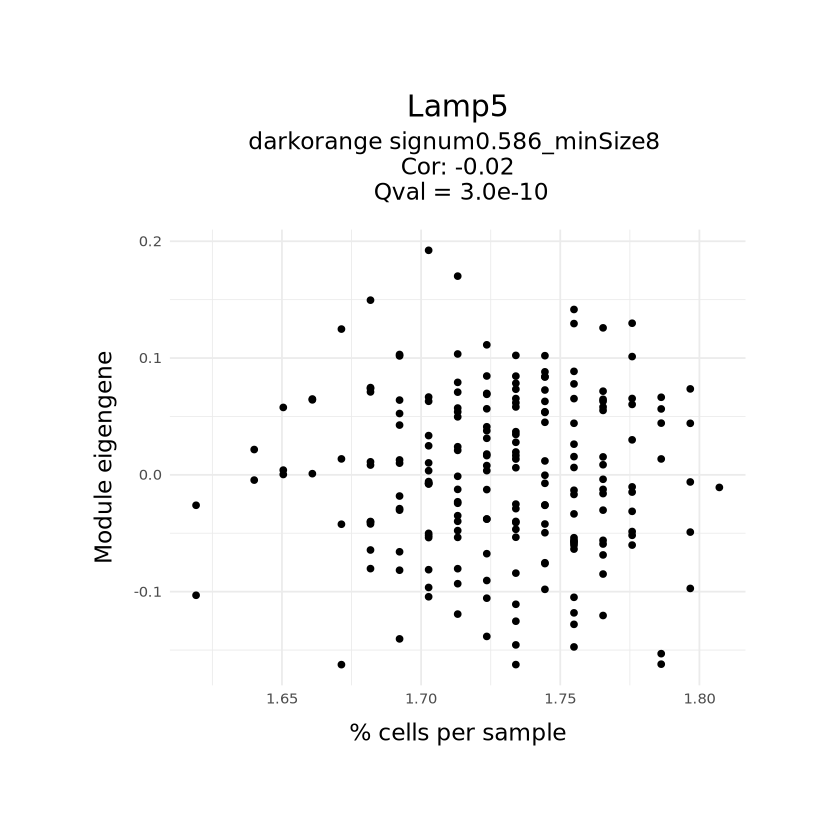

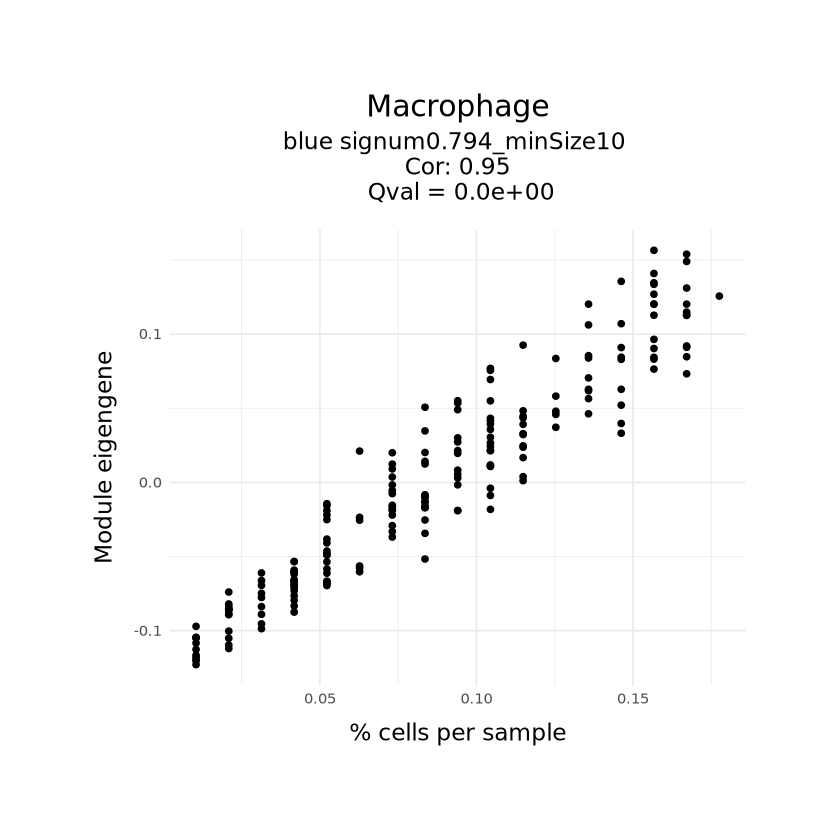

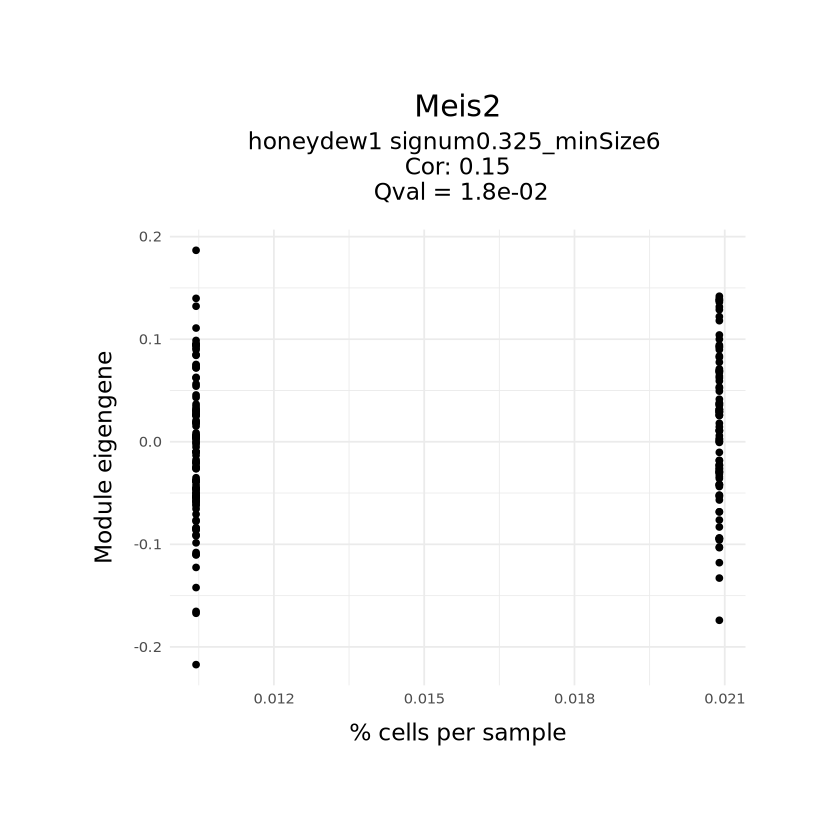

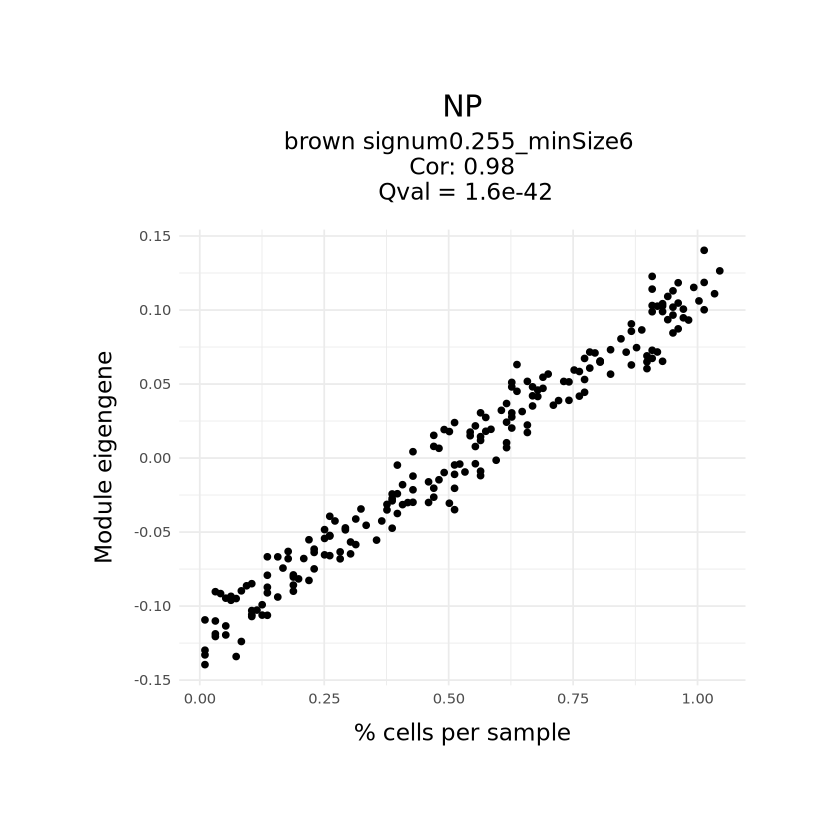

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


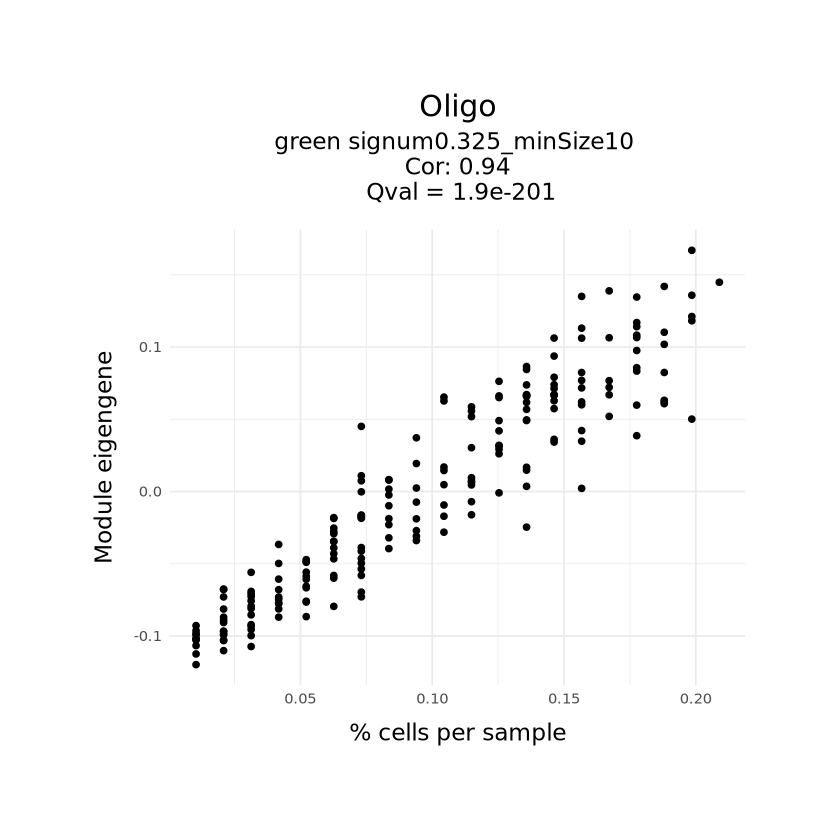

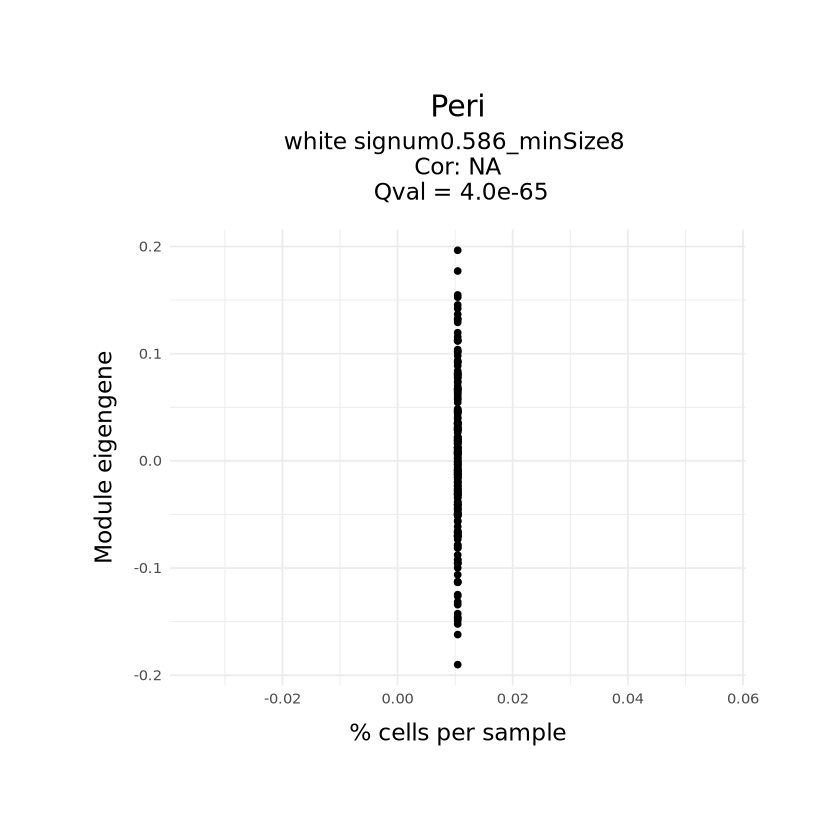

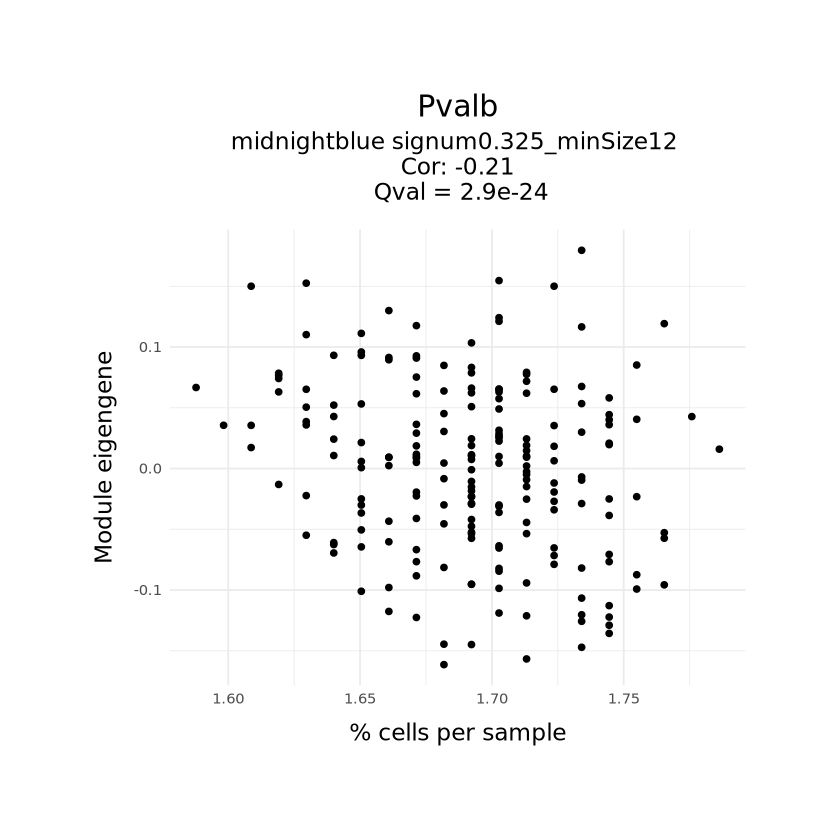

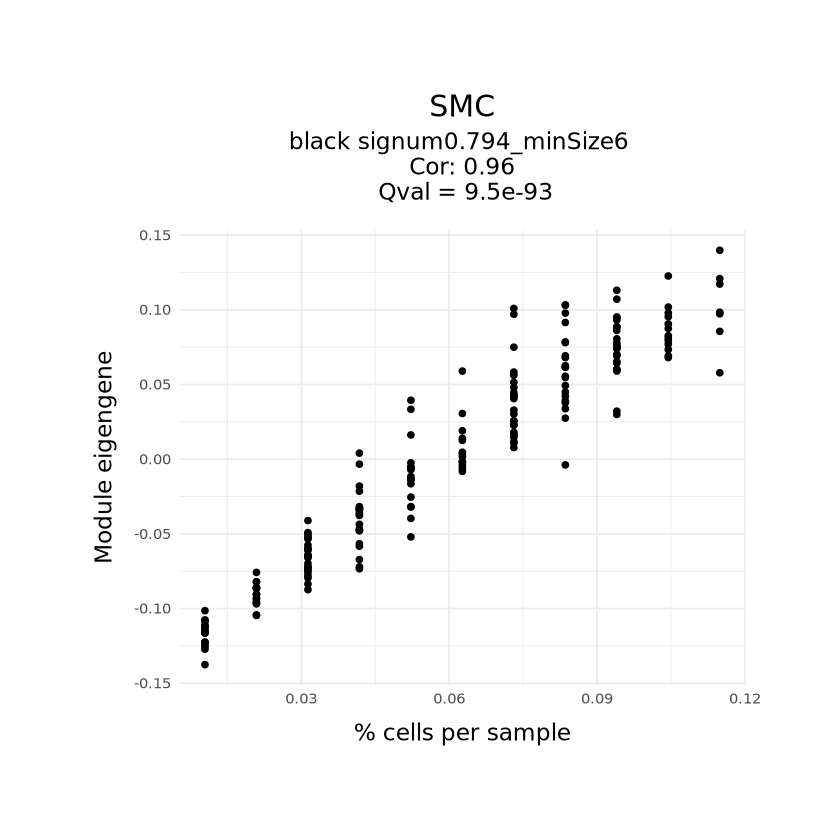

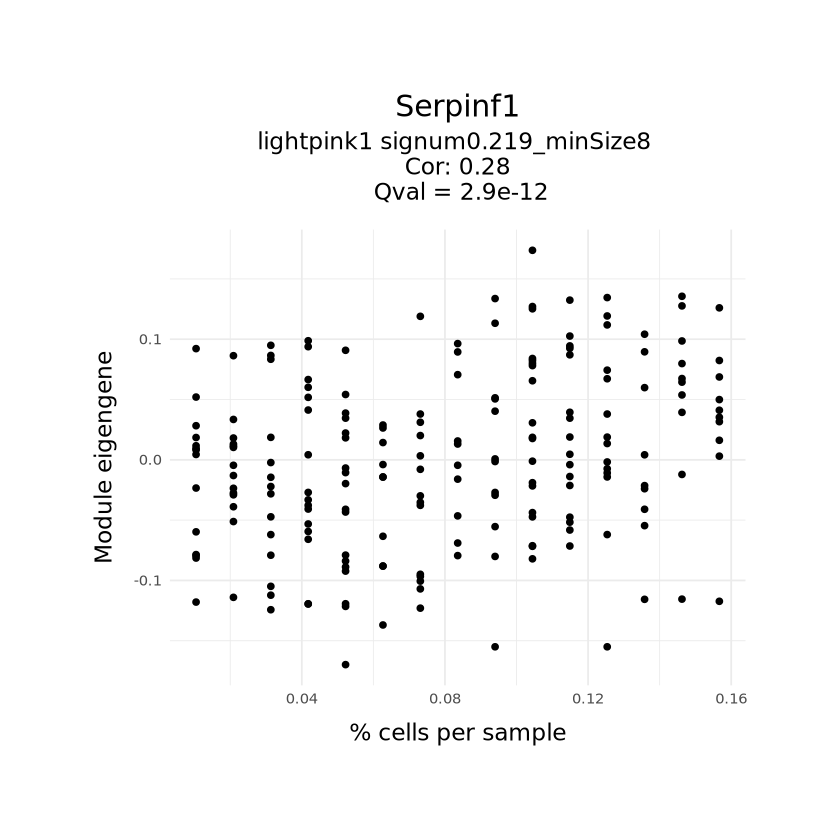

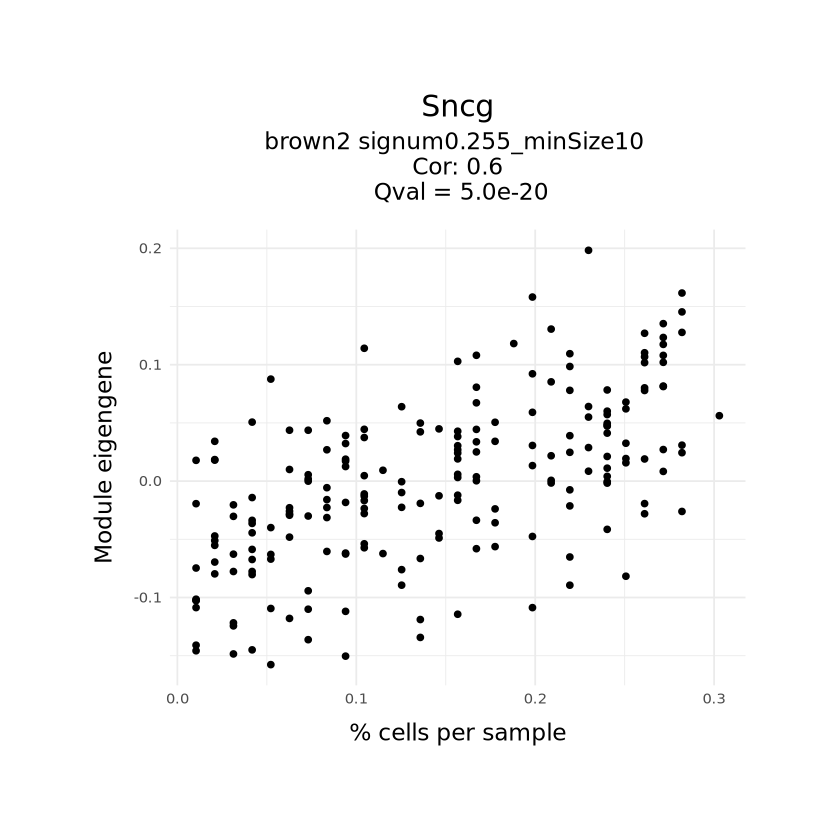

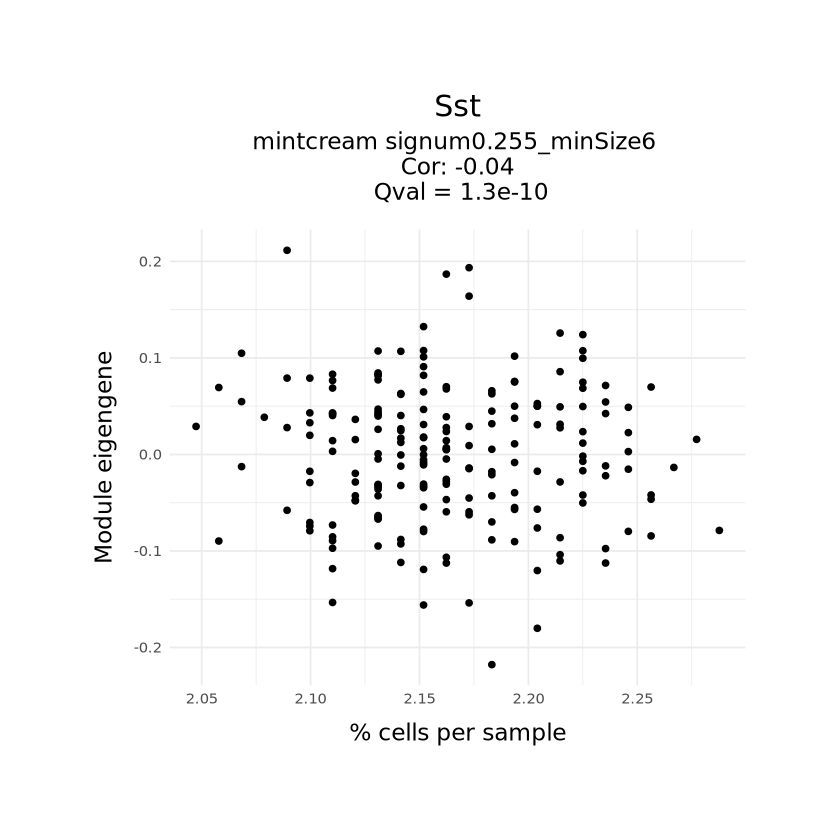

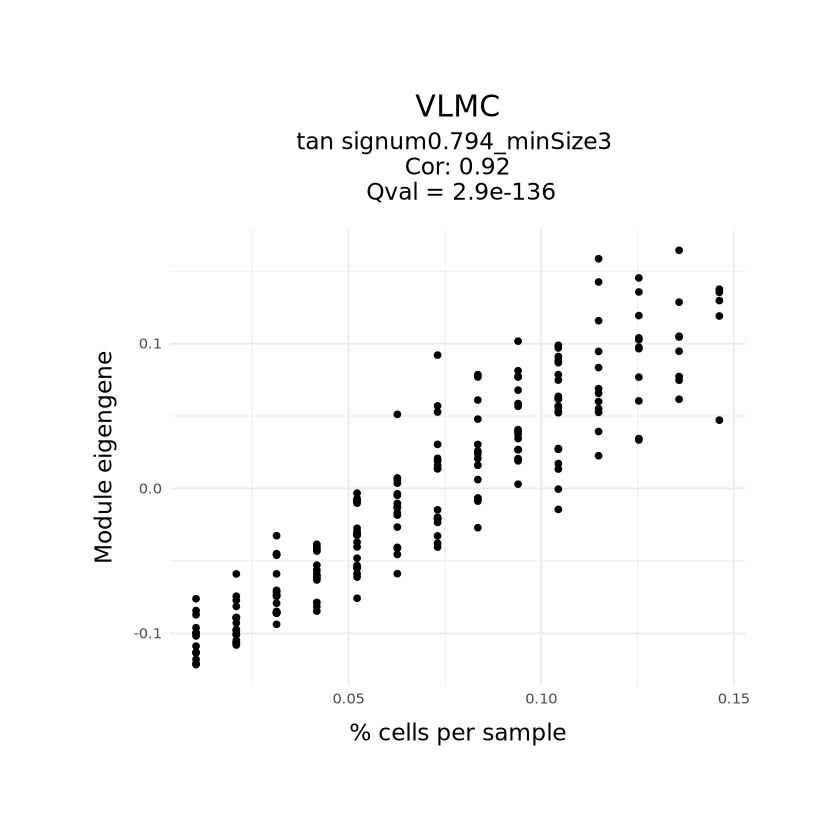

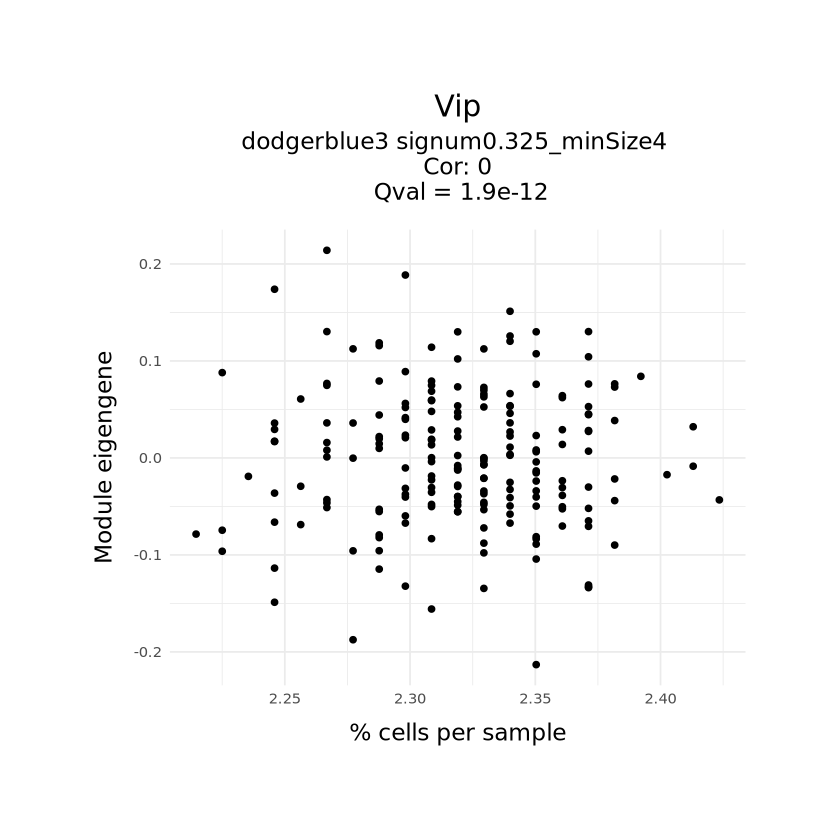

In [32]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

### For (poorly correlated) cell types, see if there exists any module(s) to which they are correlated:

In [ ]:
# For each (poorly correlated) cell types, see if there exists any module(s) to which they are correlated:

top_corr_mods_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)

In [ ]:
top_corr_mods_df

# Round 3 enrichment results (only using unique DE genes, PosBC module definiton)

In [ ]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [ ]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [ ]:
top_corr_mods_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_df

# Round 4 (new network; PosBC module definition)

In [ ]:
network_dir <- "tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_30pcntCells_50pcntVar_200samples_legend_05-16-36.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_30pcntCells_50pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [ ]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [ ]:
top_corr_mods_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_df

# Round 5 (new network; PosFDR module definition)

In [ ]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_10pcntVar_200samples_legend_11-31-12.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_20pcntCells_10pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [ ]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [ ]:
top_corr_mods_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_df

# Round 6 (new new network, PosFDR module definition)